Set up stuff

In [1]:
import cirq
import numpy as np

In [2]:
nQ = 3  # number of qubits
ns = 2**nQ  # number of field states
phi_max = 2.0  # maximum field value
t = 1.0  # time evolution step
n_steps = 1  # number of Trotter steps

In [3]:
qubits = cirq.LineQubit.range(nQ) # makes the qubits

phi_vals = np.linspace(-phi_max, phi_max, ns) # gets values of phi

We need a function that represents the $\phi^2$ term in the H equation. To do this in ```_unitary_``` we define $e^{-0.5i \phi^2 t}$ (time evolution thing):

In [11]:
def phi_squared_gate(phi_vals, t): # takes in the phi values and the time step for the evolution
    class PhiSquaredGate(cirq.Gate): # to create a custom gate we can create a class that inherits from cirq.Gate, essentially can have any abitrary behaviour
        def num_qubits(self): # every cirq gate asks "how many qubits does this gate act on?", this tells it
            return nQ
        def _unitary_(self): # what the gate actually does
            return np.diag(np.exp(-0.5j * phi_vals**2 * t)) # sticks the evolution into a diagonal matrix
        def _circuit_diagram_info_(self, args): # what to mark the gate as in the diagram
            return ["φ²"] * nQ
    return PhiSquaredGate()

Do the same thing we did for $\phi^2$ but for $\Pi^2$

In [12]:
def pi_squared_gate(ns, phi_max, t):
    k_vals = np.fft.fftfreq(ns, d=(2*phi_max)/(ns-1)) * 2 * np.pi #takes the grid set out in field space and maps it to the momentum space equivalent grid
    
    #same stuff as above
    class PiSquaredGate(cirq.Gate):
        def num_qubits(self):
            return nQ
        def _unitary_(self):
            return np.diag(np.exp(-0.5j * k_vals**2 * t))
        def _circuit_diagram_info_(self, args):
            return ["Π²"] * nQ
    return PiSquaredGate()

QFT maps a computational basis state (0 or 1) to a superposition of all momentum states k with specific phases (see D2 in savage). 

Within QFT the qubits are weighted and the lower weighted qubits are influenced by the heigher weighted ones,  so when we do ```for j in range(i+1, N):``` we are roating the phase of the lower qubits by an angle conditioned on the higher qubits, this entangles the qubits and encodes a fourier transform this is because we get "binary fractions" from the qubits which are essentially multiplications of their phases, doing these rotations gets a complex exponential: $e^{2\pi i x k/N}$ and so each of the computational basis state is mapped to a superposition of k with exactly the phases needed for a fourier transform

Also figured out theres a different way of getting a circuit out here

In [6]:
def qft(qubits): # takes in our qubits
    circuit = cirq.Circuit() # starts up an empty circuit
    N = len(qubits) # gets the number of qubits (3)
    for i in range(N): #loops over the qubits
        circuit.append(cirq.H(qubits[i])) # adds in a Hadamard on the qubit so it has an equal superposition of the basis states which allows us to entangle qubits later on in correct fourier phases
        for j in range(i+1, N): # see above text
            angle = np.pi / (2**(j-i))
            circuit.append(cirq.CZ(qubits[j], qubits[i])**(angle/np.pi))
    
    # Swap the order of the qubits as we currently have the lowest qubits first instead of last 
    for i in range(N//2):
        circuit.append(cirq.SWAP(qubits[i], qubits[N-i-1]))
    return circuit

In [7]:
def iqft(qubits): # the opposite of the above
    return cirq.inverse(qft(qubits))

Then we can make the circuit diagram of 1 trotter step for the harmonic oscillator

In [ ]:
circuit = cirq.Circuit()
for step in range(n_steps):
    circuit.append(phi_squared_gate(phi_vals, t/n_steps).on(*qubits)) # phi squared term

    circuit.append(qft(qubits)) # quantum fourier transform to momentum space

    circuit.append(pi_squared_gate(ns, phi_max, t/n_steps).on(*qubits)) # pi squared term
    
    circuit.append(iqft(qubits)) # inverse fourier transform

print(circuit)

                       ┌───────┐                                         ┌────────┐
0: ───φ²───H───@────────@──────────────────────×───Π²───×─────────────────@───────────@────────H───
      │        │        │                      │   │    │                 │           │
1: ───φ²───────@^0.5────┼─────H────@───────────┼───Π²───┼───────@─────────┼──────H────@^-0.5───────
      │                 │          │           │   │    │       │         │
2: ───φ²────────────────@^0.25─────@^0.5───H───×───Π²───×───H───@^-0.5────@^-0.25──────────────────
                       └───────┘                                         └────────┘


The above: apply the field space phase diagonal in the computational basis, then performs a QFT to move into the momentum basis, then it applies the momentum space diagonal phase, undoes the QFT returning to the field basis

In [32]:
simulator = cirq.Simulator()
initial_state = np.zeros(ns)
initial_state[0] = 1.0  # start in ground state |0>
result = simulator.simulate(circuit, initial_state=initial_state)

i=1
for result1 in result.final_state_vector:
    print(f"{i}:{result1}")
    i+=1

1:(-0.21770182251930237+0.3016648590564728j)
2:(-0.1208152323961258-0.4271436333656311j)
3:(-0.29146066308021545-0.11132590472698212j)
4:(0.05807039886713028-0.04674713686108589j)
5:(0.5099659562110901-0.040528956800699234j)
6:(0.05807039886713028-0.04674713686108589j)
7:(-0.29146066308021545-0.11132590472698212j)
8:(-0.1208152323961258-0.4271436333656311j)


When we decided on the number of qubits (3) this produced 8 basis states: ∣000⟩,∣001⟩,∣010⟩,∣011⟩,∣100⟩,∣101⟩,∣110⟩,∣111⟩, each of the 8 complex values corresponds to a probability amplitude for the field to take, the square of the magnitude of each amplitude gives the probability of measuring each of those 8 discrete values of phi within the discretised field space

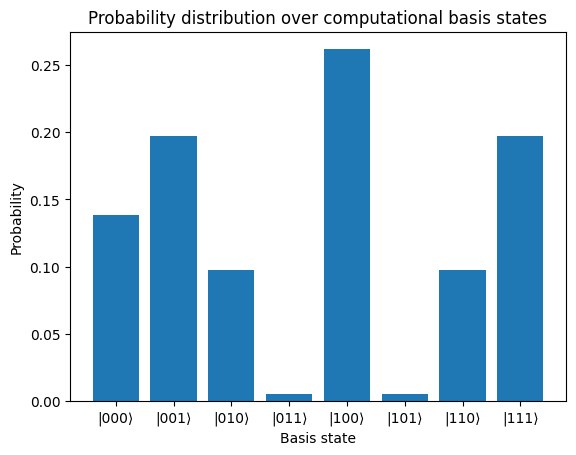

In [34]:
import matplotlib.pyplot as plt

ns = 8  
labels = [f"|{i:03b}⟩" for i in range(ns)]

# plot probabilities
plt.bar(range(ns), np.abs(result.final_state_vector)**2)
plt.xticks(range(ns), labels)
plt.xlabel("Basis state")
plt.ylabel("Probability")
plt.title("Probability distribution over computational basis states")
plt.show()